In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, silhouette_score
%matplotlib notebook
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import cross_val_score
path = '/home/piotr/chmura.put.poznan.pl/Shared/HMI_lab/emg_lab6/'

In [2]:
def rms(data, window=500, stride=100, fs=5120,
        columns_emg=['EMG_8', 'EMG_9']):  # wartści długości okna i przesunięcia w [ms]
    data = data[columns_emg]

    windows_rms = []
    windows_index = []

    for i in range(0, data.shape[0] - int(window / 1000 * fs), int(stride / 1000 * fs)):
        window_data = data.iloc[i:i + int(window / 1000 * fs)]

        window_mean = np.mean(window_data, axis=0)

        window_RMS = np.power(np.subtract(window_data, window_mean), 2)
        window_RMS = np.sqrt(window_RMS.sum(axis=0) / int(window / 1000 * fs))

        windows_rms.append(window_RMS)

        windows_index.append(window_data.index[0])

    rms_df = pd.DataFrame(windows_rms)
    rms_df.index = windows_index
    rms_df.columns = columns_emg

    return rms_df


def zc(data, threshold: float = 0.1, window: float = 500, stride: float = 100, fs=5120,
       columns_emg=['EMG_8', 'EMG_9']):  # wartści długości okna i przesunięci[column columns_emg].iloc[]
    data = data[columns_emg]

    windows_zc = []
    windows_index = []

    for i in range(0, data.shape[0] - int(window / 1000 * fs), int(stride / 1000 * fs)):
        window_data = data.iloc[i:i + int(window / 1000 * fs)]

        window_data = np.subtract(window_data, threshold)
        window_count = [len(np.where(np.diff(np.sign(window_data[col].values)))[0]) for col in columns_emg]

        windows_zc.append(window_count)

        windows_index.append(window_data.index[0])

    zc_df = pd.DataFrame(windows_zc)
    zc_df.index = windows_index
    zc_df.columns = columns_emg

    return zc_df

In [3]:
def process(data,  columns_emg=['EMG_8', 'EMG_9','EMG_17', 'EMG_10', 'EMG_11', 'EMG_12', 'EMG_13', 'EMG_14', 'EMG_15', 'EMG_16']):
    rms_features = rms(data, columns_emg=columns_emg)
    zc_features = zc(data, columns_emg=columns_emg)
    features = rms_features.join(zc_features, rsuffix='zc_', lsuffix='rms_')
    y_true = data.loc[features.index, "TRAJ_GT"]
    y_true.loc[y_true < 0] = np.nan
    nnan_idx = ~np.isnan(y_true)
    return features.loc[nnan_idx], y_true[nnan_idx]

In [27]:
path = '/home/piotr/chmura.put.poznan.pl/Shared/HMI_lab/emg_lab6/'
train = pd.read_hdf(path+'train.hdf5')
valid = pd.read_hdf(path+'test.hdf5')

train_features, train_labels = process(train, columns_emg=['EMG_8', 'EMG_9','EMG_17', 'EMG_10', 'EMG_11', 'EMG_12', 'EMG_13', 'EMG_14', 'EMG_15', 'EMG_16'])
test_features, test_labels = process(valid)

<IPython.core.display.Javascript object>


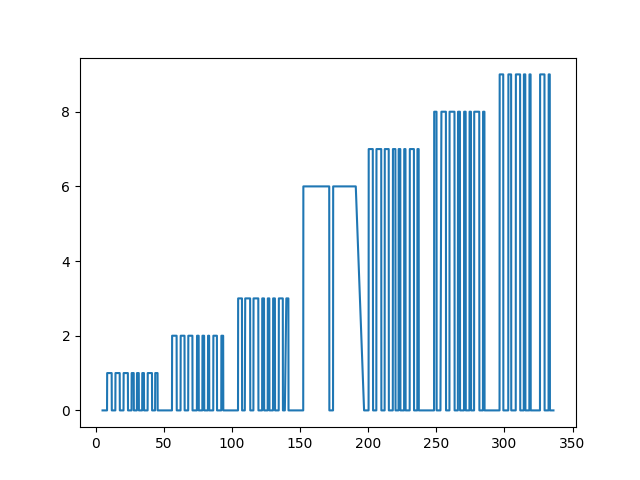

In [21]:

plt.figure()
test_labels.plot()

<IPython.core.display.Javascript object>


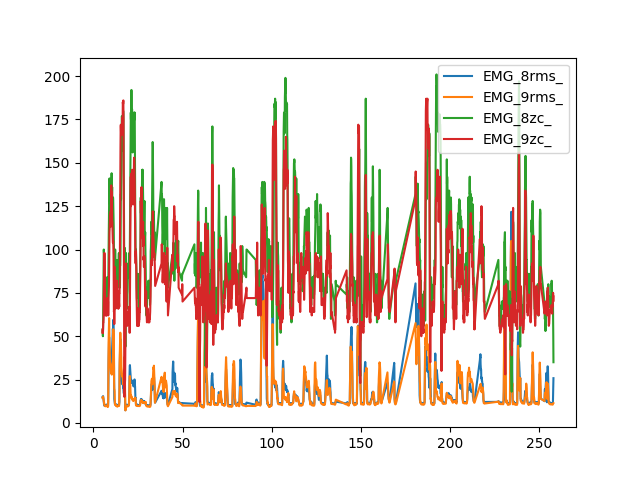

In [23]:
train_features.plot()

In [28]:
clusterer = KMeans(n_clusters=2, random_state=0)
cluster_labels = clusterer.fit_predict(train_features)
confusion_matrix(train_labels, cluster_labels)

array([[129, 918,   0,   0,   0,   0,   0,   0],
       [ 81,  37,   0,   0,   0,   0,   0,   0],
       [ 62,  51,   0,   0,   0,   0,   0,   0],
       [ 87,  41,   0,   0,   0,   0,   0,   0],
       [ 86,  71,   0,   0,   0,   0,   0,   0],
       [ 57,  43,   0,   0,   0,   0,   0,   0],
       [ 69,  56,   0,   0,   0,   0,   0,   0],
       [ 64,  71,   0,   0,   0,   0,   0,   0]])

In [29]:
clusterer = KMeans(n_clusters=8, random_state=0)
cluster_labels = clusterer.fit_predict(train_features)
confusion_matrix(train_labels, cluster_labels)

array([[528,  18,  87,  20,  13,  60, 319,   2,   0,   0],
       [  6,   0,   2,   0,  75,  11,  24,   0,   0,   0],
       [ 32,   0,   6,   2,   7,  10,   8,  48,   0,   0],
       [ 23,  78,   8,   0,   0,   5,  14,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 35,   2,  86,   0,   0,   0,  34,   0,   0,   0],
       [ 15,   0,  58,   0,   2,   0,  25,   0,   0,   0],
       [ 12,   0,  76,   0,   0,   0,  37,   0,   0,   0],
       [ 31,   0,  69,   0,   0,   0,  35,   0,   0,   0]])

In [30]:
names = [ "Random Forest", "LDA", "Neural Net"]
classifiers = [    
    RandomForestClassifier(n_estimators=100, random_state = 0),
    MLPClassifier(alpha=0.9, max_iter=1000, random_state = 0),
    LinearDiscriminantAnalysis()
   ]

for name, clf in zip(names, classifiers):
      scores = cross_val_score(clf, train_features, train_labels, cv=5,  scoring='precision_macro')
      print(name, ', precision mean:', np.mean(scores), "std: ", np.std(scores))

/home/piotr/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Random Forest , precision mean: 0.7327802844363085 std:  0.11961392975304842


/home/piotr/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LDA , precision mean: 0.6075701062308845 std:  0.08570707880306352
Neural Net , precision mean: 0.6768755454017032 std:  0.10900331823059634
